In [3]:
# Phase 3 – Step 3: Load skeleton input

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread

# Explicit project root (robust)
project_root = Path.home() / "FundusGNN_Project"
print("Project root:", project_root)

# Sanity check: DRIVE training images
train_path = project_root / "data" / "raw" / "DRIVE" / "training" / "images"
images = list(train_path.glob("*.tif"))

print("Number of training images:", len(images))




Project root: C:\Users\amrit\FundusGNN_Project
Number of training images: 20


In [4]:
from scipy.ndimage import convolve

try:
    skeleton
except NameError:
    print("Skeleton not found yet. We will generate it next step.")


Skeleton not found yet. We will generate it next step.


In [6]:
# Phase 3 – Generate skeleton (same logic as Phase 2)

import cv2
from skimage.filters import frangi
from skimage.morphology import skeletonize

# Load ONE fundus image (example: first training image)
img_path = images[0]
img = cv2.imread(str(img_path))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Green channel
green = img[:, :, 1]

# CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
green_clahe = clahe.apply(green)

# Frangi vessel enhancement
vessels_frangi = frangi(green_clahe / 255.0)

# Binary vessel mask
binary_vessels = vessels_frangi > 0.02

# Skeletonization
skeleton = skeletonize(binary_vessels)

print("Skeleton generated:", skeleton.shape)


Skeleton generated: (584, 565)


In [7]:
# 8-connected neighborhood kernel
kernel = np.array([
    [1, 1, 1],
    [1, 10, 1],
    [1, 1, 1]
])

# Convolve skeleton to count neighbors
neighbor_count = convolve(skeleton.astype(int), kernel, mode="constant", cval=0)

# Endpoint condition:
# skeleton pixel (10) + exactly ONE neighbor (1) → total = 11
endpoints = (neighbor_count == 11)

print("Number of endpoints detected:", np.sum(endpoints))


Number of endpoints detected: 1678


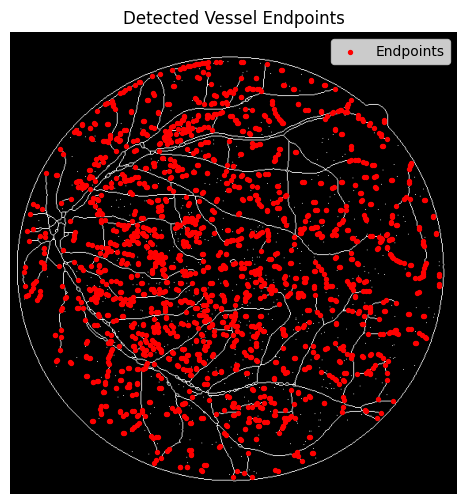

In [8]:
plt.figure(figsize=(6,6))
plt.imshow(skeleton, cmap="gray")
plt.scatter(
    np.where(endpoints)[1],
    np.where(endpoints)[0],
    c="red",
    s=8,
    label="Endpoints"
)
plt.title("Detected Vessel Endpoints")
plt.axis("off")
plt.legend()
plt.show()


In [9]:
from skimage.morphology import remove_small_objects

# Remove very small skeleton fragments (noise)
# This threshold is intentionally small
clean_skeleton = remove_small_objects(
    skeleton,
    min_size=30,   # remove components smaller than 30 pixels
    connectivity=2
)

print("Original skeleton pixels:", np.sum(skeleton))
print("Cleaned skeleton pixels:", np.sum(clean_skeleton))


Original skeleton pixels: 11339
Cleaned skeleton pixels: 7544


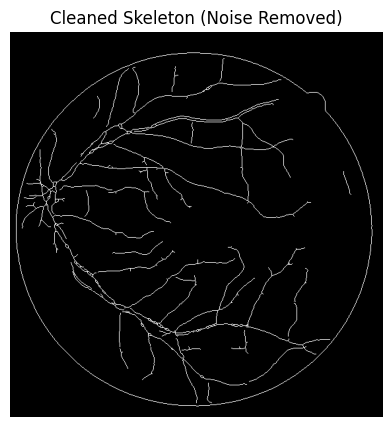

In [10]:
plt.figure(figsize=(5,5))
plt.imshow(clean_skeleton, cmap="gray")
plt.title("Cleaned Skeleton (Noise Removed)")
plt.axis("off")
plt.show()


In [11]:
neighbor_count_clean = convolve(clean_skeleton.astype(int), kernel, mode="constant", cval=0)
endpoints_clean = (neighbor_count_clean == 11)

print("Endpoints after cleanup:", np.sum(endpoints_clean))


Endpoints after cleanup: 138


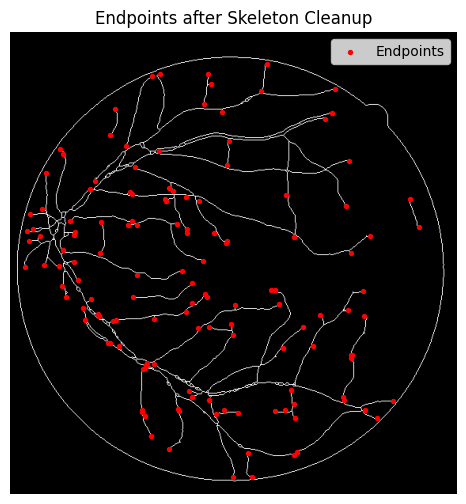

In [24]:
plt.figure(figsize=(6,6))
plt.imshow(clean_skeleton, cmap="gray")
plt.scatter(
    np.where(endpoints_clean)[1],
    np.where(endpoints_clean)[0],
    c="red",
    s=8,
    label="Endpoints"
)
plt.title("Endpoints after Skeleton Cleanup")
plt.axis("off")
plt.legend()
plt.show()
skeleton_cleaned = clean_skeleton


In [25]:
# Junctions from CLEAN skeleton
junctions_clean = (neighbor_count_clean >= 13)

print("Clean junctions:", np.sum(junctions_clean))


Clean junctions: 786


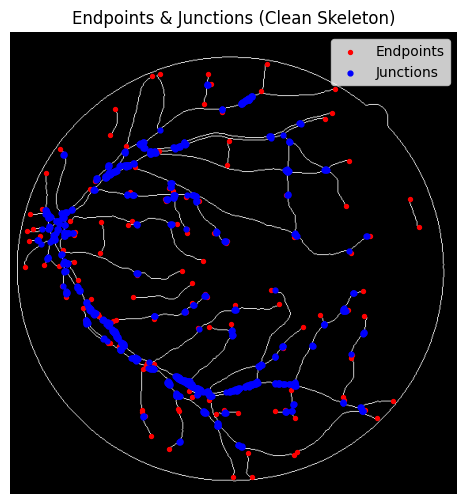

In [26]:
plt.figure(figsize=(6,6))
plt.imshow(skeleton_cleaned, cmap="gray")

# Endpoints (red)
plt.scatter(
    np.where(endpoints_clean)[1],
    np.where(endpoints_clean)[0],
    c="red",
    s=8,
    label="Endpoints"
)

# Junctions (blue)
plt.scatter(
    np.where(junctions_clean)[1],
    np.where(junctions_clean)[0],
    c="blue",
    s=12,
    label="Junctions"
)

plt.title("Endpoints & Junctions (Clean Skeleton)")
plt.axis("off")
plt.legend()
plt.show()



In [27]:
import networkx as nx

G = nx.Graph()
node_coords = []

# CLEAN endpoints
for y, x in zip(*np.where(endpoints_clean)):
    node_coords.append((x, y))

# CLEAN junctions
for y, x in zip(*np.where(junctions_clean)):
    node_coords.append((x, y))

# Add nodes
for i, (x, y) in enumerate(node_coords):
    G.add_node(i, pos=(x, y))

print("Clean graph nodes:", G.number_of_nodes())


Clean graph nodes: 924


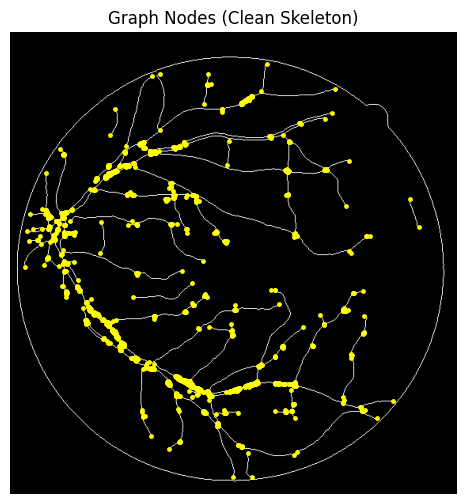

In [28]:
plt.figure(figsize=(6,6))
plt.imshow(skeleton_cleaned, cmap="gray")

xs = [p[0] for p in node_coords]
ys = [p[1] for p in node_coords]

plt.scatter(xs, ys, c="yellow", s=6)
plt.title("Graph Nodes (Clean Skeleton)")
plt.axis("off")
plt.show()
